In [145]:
import numpy as np
import time
from tinygrad.tensor import Tensor
from tinygrad.nn import Linear
from tinygrad.nn.optim import Adam

class AutoEncoder:
  def __init__(self, input_dim=784, latent_dim=128):
    # Encoder
    self.c1 = Tensor.scaled_uniform(8,1,3,3)
    self.c2 = Tensor.scaled_uniform(16,8,3,3)
    self.l3 = Linear(16*5*5, latent_dim)

    # Decoder
    self.l4 = Linear(latent_dim, 16*5*5)
    self.l5 = Linear(16*5*5, input_dim)

  def encoder(self, x):
    x = x.reshape(shape=(-1, 1, 28, 28)) 
    x = x.conv2d(self.c1).relu().max_pool2d()
    x = x.conv2d(self.c2).relu().max_pool2d()
    x = x.reshape(shape=[x.shape[0], -1])
    x = self.l3(x)
    return x

  def decoder(self, x):
    x = self.l4(x).relu()
    x = self.l5(x)
    return x.sigmoid()

  def __call__(self, x):
    x = self.encoder(x)
    return self.decoder(x)
  
def mse_loss(out, target):
  return ((out-target)**2).mean() + 1e-10  # add small constant to prevent loss becoming zero

# Initialize the autoencoder and set to training mode
autoencoder = AutoEncoder()
Tensor.training = True

# Load and normalize the data
from datasets import fetch_mnist
X_train, Y_train, X_test, Y_test = fetch_mnist()

# Normalize data to [0, 1] range and convert to float32
X_train, X_test = X_train.astype(np.float32) / 255. , X_test.astype(np.float32) /255.

opt = Adam([
    autoencoder.c1, 
    autoencoder.c2, 
    autoencoder.l3.weight, 
    autoencoder.l3.bias,
    autoencoder.l4.weight,
    autoencoder.l4.bias,
    autoencoder.l5.weight,
    autoencoder.l5.bias
], lr=0.0001)

# Training
for step in range(2000):
  #random sample a batch
  samp = np.random.randint(0, X_train.shape[0], size=(64))

  batch = Tensor(X_train[samp], requires_grad=False)

  #forward pass
  out = autoencoder(batch)

  #compute loss
  loss = mse_loss(out, batch)

  #zero grad
  opt.zero_grad()

  #backward
  loss.backward()

  #update parameters
  opt.step()

  if step % 10 == 0:
    print(f"Step {step+1} | Loss: {loss.numpy()}")


# EVALUATION
Tensor.training = False
st = time.perf_counter()
avg_loss = 0

for step in range(1000):
  #random sample a batch
  samp = np.random.randint(0, X_test.shape[0], size=(64))
  batch = Tensor(X_test[samp], requires_grad=False)

  #forward pass
  out = autoencoder(batch)

  #compute loss
  loss = mse_loss(out, batch)
  avg_loss += loss.numpy()

print(f"Test Loss: {avg_loss / 1000}")
print(f"Time: {time.perf_counter() - st}")

Step 1 | Loss: 0.23187685012817383
Step 11 | Loss: 0.22970084846019745
Step 21 | Loss: 0.22640858590602875
Step 31 | Loss: 0.22374992072582245
Step 41 | Loss: 0.21704763174057007
Step 51 | Loss: 0.20594574511051178
Step 61 | Loss: 0.18459850549697876
Step 71 | Loss: 0.1478639543056488
Step 81 | Loss: 0.11184652894735336
Step 91 | Loss: 0.08604833483695984
Step 101 | Loss: 0.07255684584379196
Step 111 | Loss: 0.0712285190820694
Step 121 | Loss: 0.07409068942070007
Step 131 | Loss: 0.0741250142455101
Step 141 | Loss: 0.07365250587463379
Step 151 | Loss: 0.07309883087873459
Step 161 | Loss: 0.07008861750364304
Step 171 | Loss: 0.07028976082801819
Step 181 | Loss: 0.07283397018909454
Step 191 | Loss: 0.0689912885427475
Step 201 | Loss: 0.07245870679616928
Step 211 | Loss: 0.06722833216190338
Step 221 | Loss: 0.07098506391048431
Step 231 | Loss: 0.06558547914028168
Step 241 | Loss: 0.07376056164503098
Step 251 | Loss: 0.0708145722746849
Step 261 | Loss: 0.06882547587156296
Step 271 | Loss: 

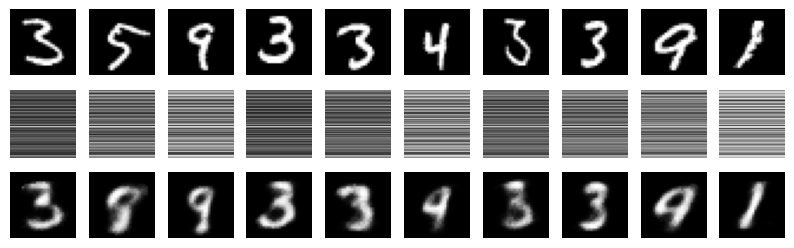

In [146]:
import matplotlib.pyplot as plt

# select a random batch of images
samp = np.random.randint(0, X_test.shape[0], size=(10))
batch = Tensor(X_test[samp], requires_grad=False)

# forward pass through the autoencoder
out = autoencoder(batch)

# get the encoded representation by only passing through the encoder
encoded = autoencoder.encoder(batch)

# plot the original images, the encoded representation and the decoded images
fig, axs = plt.subplots(3, 10, figsize=(10, 3))

for i in range(10):
    # plot original images
    axs[0, i].imshow(batch[i].numpy().reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')

    # plot encoded representation
    encoded_img = encoded[i].numpy()
    encoded_img = encoded_img.reshape(-1, 1)  # reshape into a 1D array
    axs[1, i].imshow(encoded_img, aspect='auto', cmap='gray')
    axs[1, i].axis('off')

    # plot decoded images
    axs[2, i].imshow(out[i].numpy().reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')

plt.show()

